<h1 style="text-align: center;">Proyect 2 - Stock Forecasting with RNNs, LSTMs and GRU</h1>

<h4 style="text-align: center;">

Roi Jared Flores Garza Stone

Esteban Gomez Valerio

Ivan Morales Camacho

Rafael Takata Garcia

Machine Learning - O2025_MAF3654H

Ing. Juan Antonio Vega Fernández, M. Sc., M. T. Ed

ITESO
</h4>

---

### Introduction

Financial markets are inherently complex, noisy, and non-linear systems, making accurate forecasting of asset prices one of the most challenging and valuable problems in quantitative finance. The ability to predict future stock prices or returns, even over a short horizon, is crucial for developing profitable trading strategies, managing risk, and optimizing investment portfolios.

Traditional time series models, such as ARIMA (Autoregressive Integrated Moving Average), rely on strict statistical assumptions (like linearity and stationarity) that often fail to capture the subtle, long-range temporal dependencies and complex non-linear dynamics inherent in high-frequency financial data.

### Objective

This Jupyter Notebook aims to address these challenges by employing modern Recurrent Neural Network (RNN) architectures, specifically Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU). In this case, we will use the 

---

### Libraries:

In [25]:
import pandas as pd
import seaborn as sns
from datetime import date
from collections import defaultdict
import yfinance as yf
import numpy as np
import math
from prophet import Prophet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [30]:
#!pip install yfinance
#!pip install scikit-learn
#!pip install seaborn
#!pip install mplfinance
#!pip install prophet

### Import data:

In [4]:
symbol = "ORCL"
data_ticker = yf.Ticker(symbol)
data = data_ticker.history(period="3mo")
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-08-20 00:00:00-04:00,231.777771,235.471373,227.854586,234.652786,11256400,0.0,0.0
2025-08-21 00:00:00-04:00,232.646278,235.511301,232.027342,232.756088,7403100,0.0,0.0
2025-08-22 00:00:00-04:00,233.654530,238.086841,231.059043,235.960526,9343600,0.0,0.0
2025-08-25 00:00:00-04:00,236.938839,238.615921,234.862440,235.002197,6308600,0.0,0.0
2025-08-26 00:00:00-04:00,234.592900,236.499595,232.306874,233.804276,11805200,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-13 00:00:00-05:00,224.990005,225.160004,215.220001,217.570007,30009000,0.0,0.0
2025-11-14 00:00:00-05:00,210.830002,227.050003,210.770004,222.850006,36053800,0.0,0.0
2025-11-17 00:00:00-05:00,218.210007,222.800003,215.559998,219.860001,16143800,0.0,0.0


In [5]:
end_date = date.today().strftime("%Y-%m-%d")
start_date = "2000-01-01"

df = yf.download('ORCL', start=start_date, end=end_date)

df.columns = df.columns.droplevel()
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

print(df.head())
print(df.tail())
print(df.info())

C:\Users\ivanm\AppData\Local\Temp\ipykernel_20228\1536951313.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('ORCL', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close     Volume
Date                                                             
2000-01-03  23.673803  25.089221  22.371118  24.976489   98114800
2000-01-04  21.581999  23.774018  21.043388  23.147727  116824800
2000-01-05  20.442148  21.318956  19.239669  20.366993  166054000
2000-01-06  19.239666  21.043385  18.976624  20.072633  109880000
2000-01-07  20.717718  20.742770  18.751163  19.039257   91755600
                  Open        High         Low       Close    Volume
Date                                                                
2025-11-12  226.990005  236.809998  226.169998  236.740005  24195000
2025-11-13  217.570007  225.160004  215.220001  224.990005  30009000
2025-11-14  222.850006  227.050003  210.770004  210.830002  36053800
2025-11-17  219.860001  222.800003  215.559998  218.210007  16143800
2025-11-18  220.490005  223.699997  214.500000  216.210007  21098300
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65

## Plotting the data

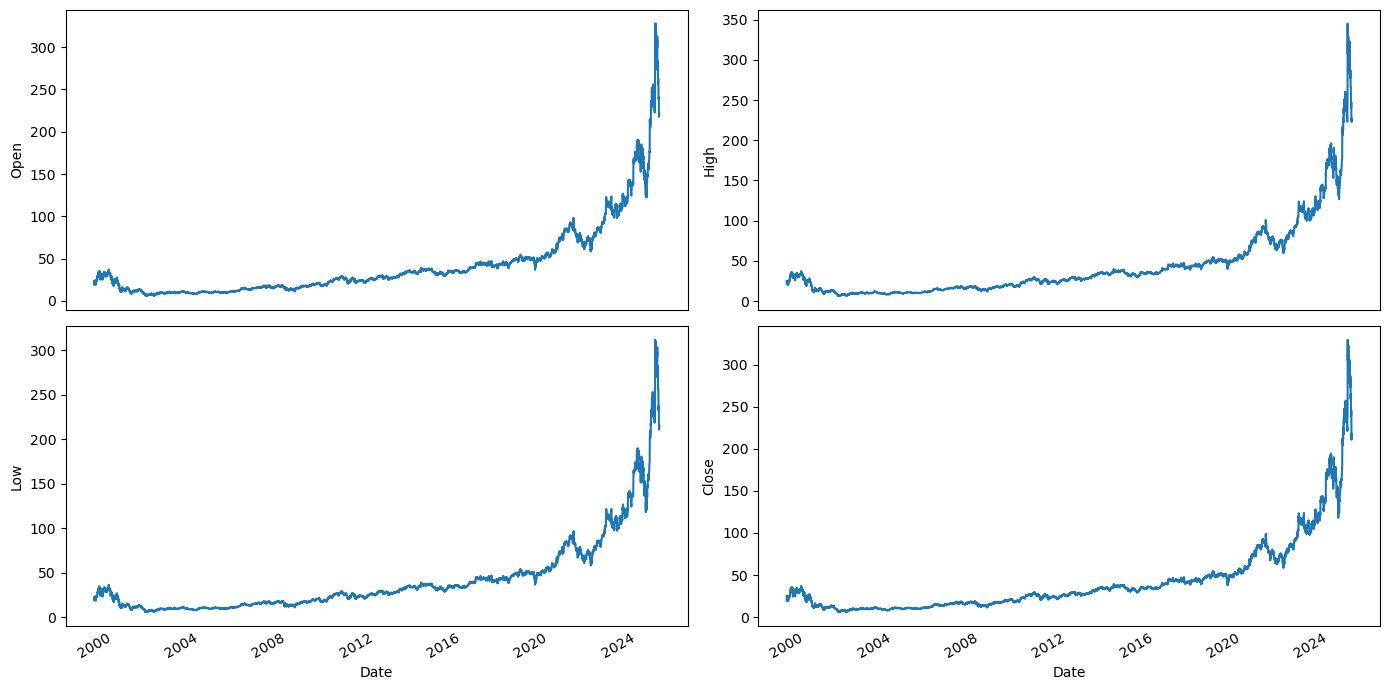

In [6]:
import matplotlib.dates as mdates

def data_plotter(df):
    df_plot = df.copy()
    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))

    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show

data_plotter(df)
        

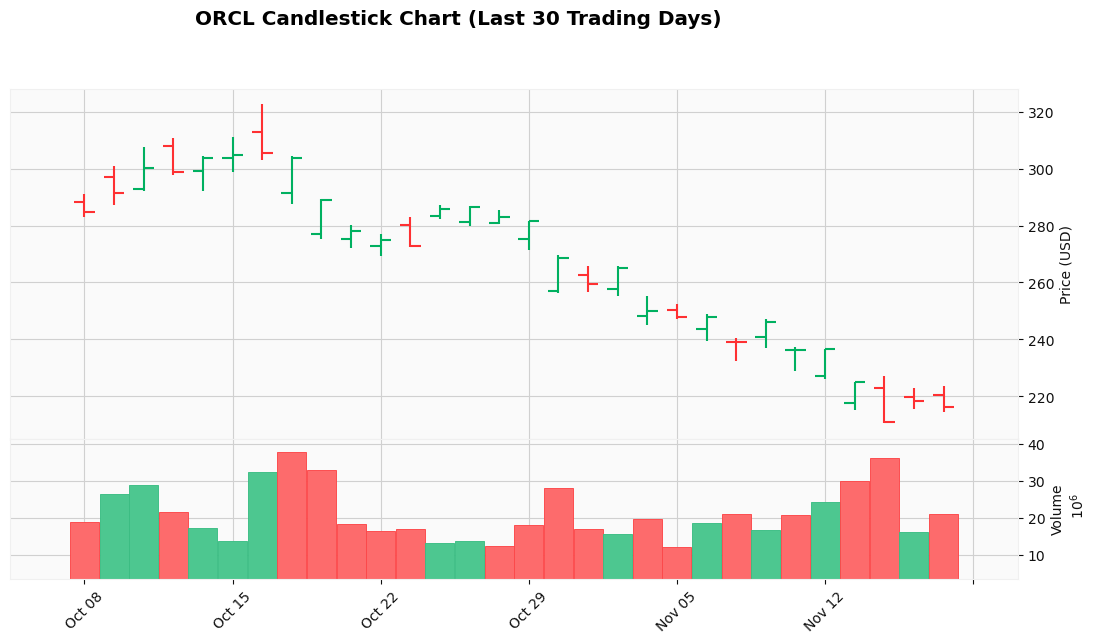

In [ ]:
import mplfinance as mpf

# Select the last 30 trading days for visualization (1 month)
df_candlestick = df.tail(30).copy()

mpf.plot(
    df_candlestick,
    type='ohlc',
    style='yahoo',
    volume=True,
    title='ORCL Candlestick Chart (Last 30 Trading Days)',
    ylabel='Price (USD)',
    ylabel_lower='Volume',
    figsize=(14, 7)
)

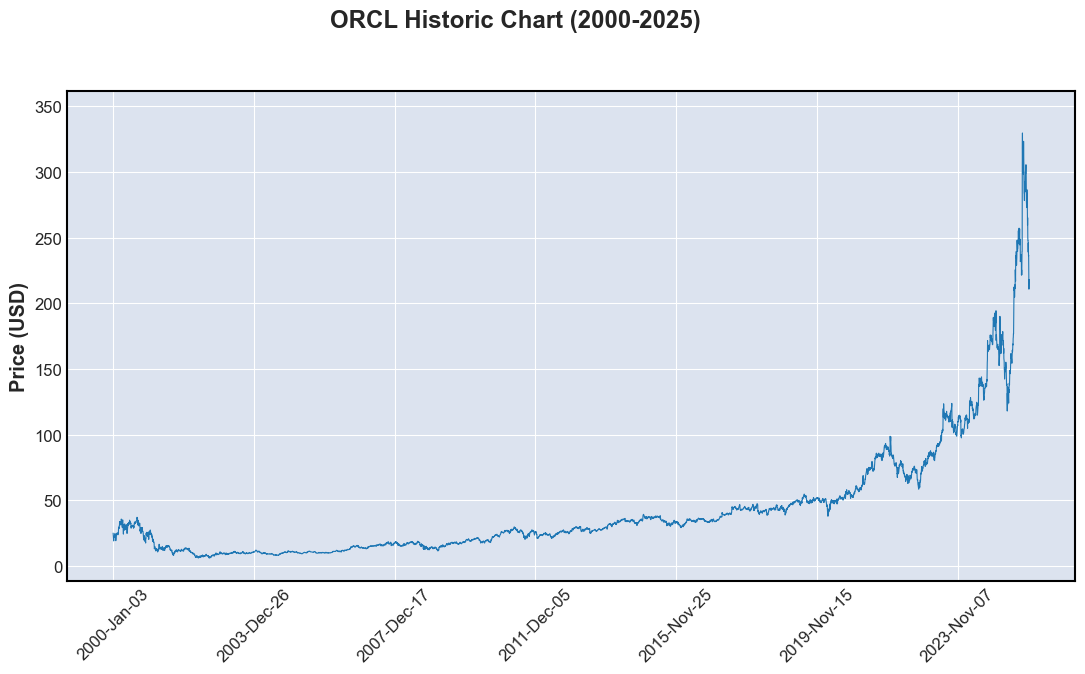

In [8]:
mpf.plot(
    df,
    type='line',
    title='ORCL Historic Chart (2000-2025)',
    ylabel='Price (USD)',
    figsize=(14,7))

# Digging into de data

As we can see on the chart above, ORCL action had a really stable and healthy price going up in a conservative for over 11 years, lets dig a little bit deeper and see how three main events, just for curiosity, affected the price of this gigantic tech Company. COVID-19 pandemic, 9/11 and ChatGPT release on november the 30th 2022.

In [31]:
# Lambda function to slice the historical DataFrame 'df' by date range
extract_period = lambda data, start, end: data.loc[start:end].copy()

In [10]:
#9/11
end_date = "2001-10-11"
start_date = "2001-08-11"
df_9_11 = extract_period(df, start_date, end_date)

In [11]:
# GPT release
end_date = "2022-12-15"
start_date = "2022-11-25"
df_Chat_GPT = extract_period(df, start_date, end_date)

In [12]:
# Covid-19 Pandemic
end_date = "2023-05-05"
start_date = "2020-01-21"
df_COVID = extract_period(df, start_date, end_date)

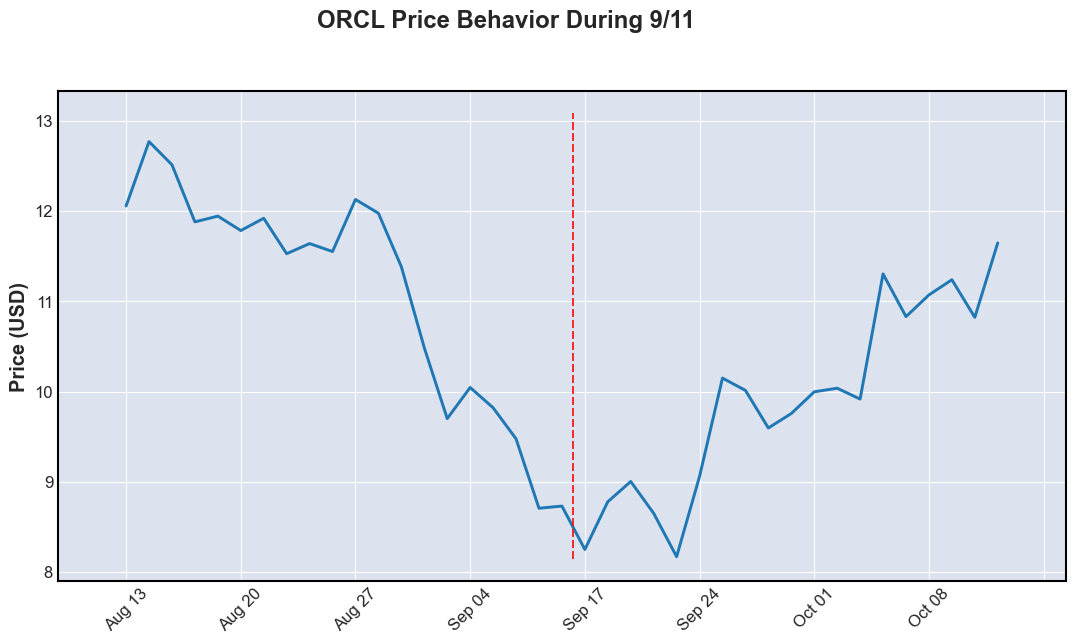

In [ ]:
# 1. Define the date as a simple list of one string for visualization
vline_dates = ['2001-09-11']

# 2. Create a single configuration dictionary for vline configuration
vlines_config = {
    'vlines': vline_dates,
    'colors': 'red',
    'linewidths': 1.5,
    'linestyle': '--',
    'alpha': 0.8
}

# 3. Plotting with vline for visual emphasis on the event date
mpf.plot(
    df_9_11,
    type='line',
    title='ORCL Price Behavior During 9/11',
    ylabel='Price (USD)',
    figsize=(14, 7),
    vlines=vlines_config,
)

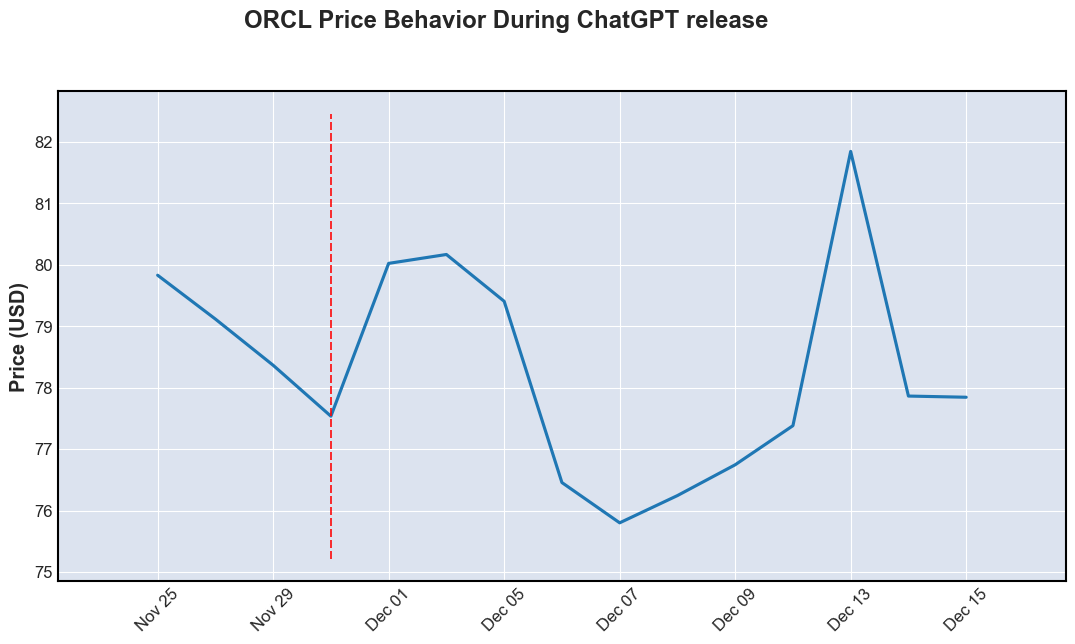

In [ ]:
# 1. Define the date as a simple list of one string for visualization
vline_dates = ['2022-11-30']

# 2. Create a single configuration dictionary for vline configuration
vlines_config = {
    'vlines': vline_dates,
    'colors': 'red',
    'linewidths': 1.5,
    'linestyle': '--',
    'alpha': 0.8
}

# 3. Plotting with vline for visual emphasis on the event date
mpf.plot(
    df_Chat_GPT,
    type='line',
    title='ORCL Price Behavior During ChatGPT release',
    ylabel='Price (USD)',
    figsize=(14, 7),
    vlines=vlines_config,  
)

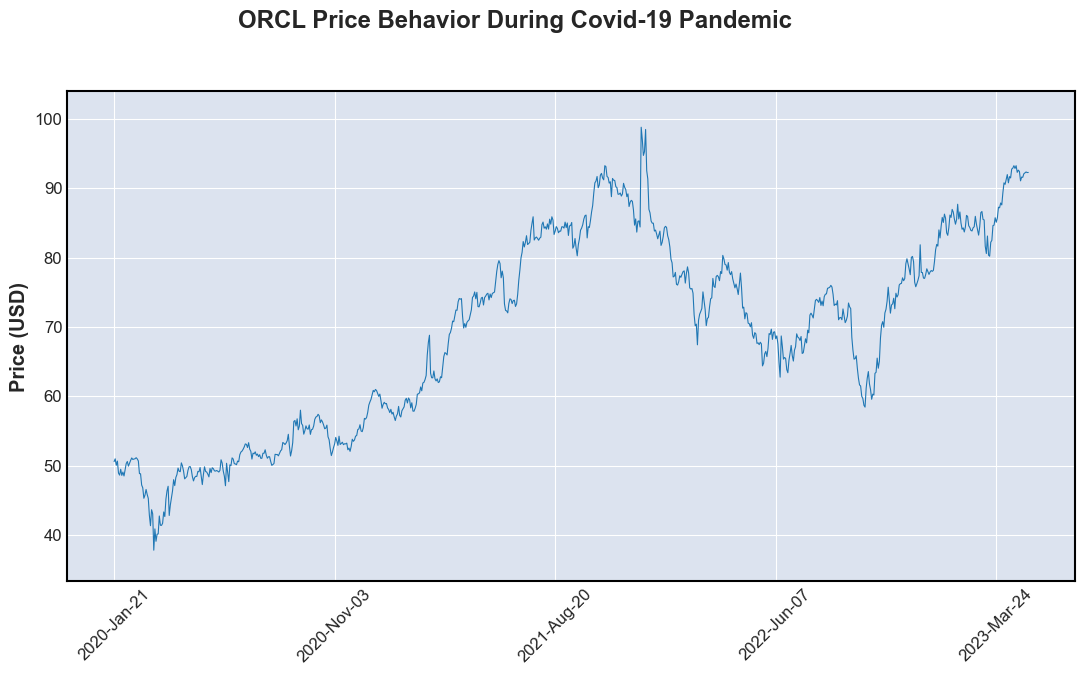

In [15]:
mpf.plot(
    df_COVID,
    type='line',
    title='ORCL Price Behavior During Covid-19 Pandemic',
    ylabel='Price (USD)',
    figsize=(14, 7)
)

## Preprocessing the data

Here we are going to use MinMaxScaler from sklearn in order to help the NNs to converge faster.

In [ ]:
# Train test split 80/20
training_data_len = math.ceil(len(df) * .8)
print(f"The training dataset consists of {training_data_len} instances")

# Splitting the dataset
train_data = df[:training_data_len].iloc[:, :1]
test_data = df[training_data_len:].iloc[:, :1]

# Selecting Open Price values
dataset_train = train_data.Open.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
print(f"Training shape is: {dataset_train.shape}")

# Selecting Open Price values
dataset_test = test_data.Open.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
print(f"Test shape is: {dataset_test.shape}")

scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling training dataset between 0 and 1
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

# Scaling test dataset between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(scaled_test[:5])

The training dataset consists of 5208 instances
Training shape is: (5208, 1)
Test shape is: (1302, 1)
[[0.36066362]
 [0.31829305]
 [0.29520479]
 [0.2708479 ]
 [0.3007866 ]]
[[0.01725546]
 [0.01553829]
 [0.01469655]
 [0.01324873]
 [0.01685144]]


In [17]:
# Create sequences and labels for training data
sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])  # Predicting the value right after the sequence
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([5158, 50, 1]) torch.Size([5158, 1])
torch.Size([1272, 30, 1]) torch.Size([1272, 1])


## LSTM

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

print("Initializing LSTM Model...")
print(f"Training on device: {device}")

input_size = 1
num_layers = 3  # Increased number of layers
hidden_size = 128  # Increased number of hidden units
output_size = 1
dropout = 0.2  # Added dropout for regularization

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Learning rate 0.001

batch_size = 32  # Adjusted batch size
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 100  # Increased number of epochs
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Initializing LSTM Model...
Training on device: cuda
Epoch [10/100] - Training Loss: 0.0005, Test Loss: 0.0008
Epoch [20/100] - Training Loss: 0.0004, Test Loss: 0.0005
Epoch [30/100] - Training Loss: 0.0003, Test Loss: 0.0003
Epoch [40/100] - Training Loss: 0.0003, Test Loss: 0.0003
Epoch [50/100] - Training Loss: 0.0002, Test Loss: 0.0003
Epoch [60/100] - Training Loss: 0.0002, Test Loss: 0.0003
Epoch [70/100] - Training Loss: 0.0002, Test Loss: 0.0003
Epoch [80/100] - Training Loss: 0.0002, Test Loss: 0.0003
Epoch [90/100] - Training Loss: 0.0002, Test Loss: 0.0003
Epoch [100/100] - Training Loss: 0.0002, Test Loss: 0.0003


## Loss function for LSTM

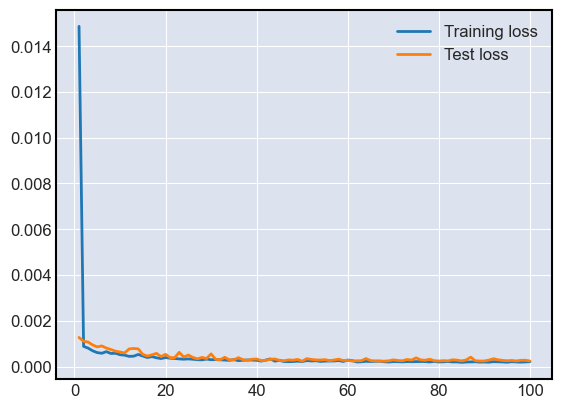

In [ ]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

## Forecasting with LSTM

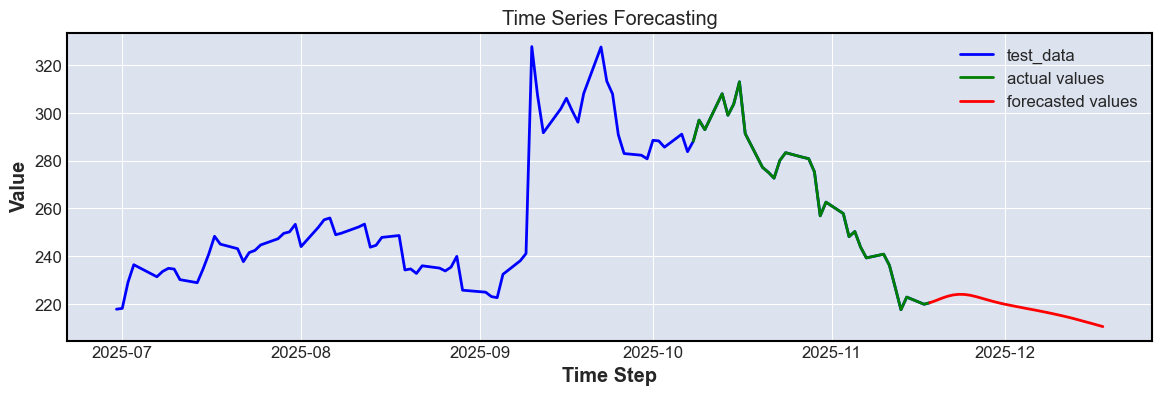

RMSE: 0.0154
R^2 Score: 0.9941


In [35]:
num_forecast_steps = 30
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(test_data.index[-100:], test_data.Open[-100:], label="test_data", color="b")
plt.plot(test_data.index[-30:], test_data.Open[-30:], label='actual values', color='green')
plt.plot(test_data.index[-1:].append(future_dates), np.concatenate([test_data.Open[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()]), label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.show()

# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R^2 Score: {r2:.4f}')

LSTM Model Performance:
RMSE: 0.0156
R2 Score: 0.9939


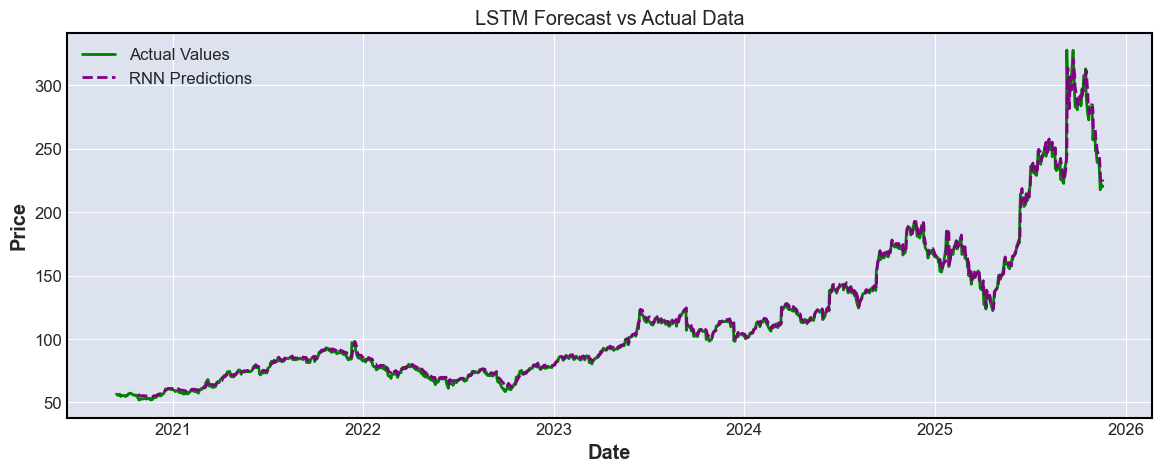

In [42]:
# --- Evaluation Metrics ---
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f"LSTM Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# --- Plotting Predictions vs Actual ---
plt.figure(figsize=(14, 5))
plt.plot(test_data.index, test_data.Open, label='Actual Values', color='green')
# We need to align predictions with dates (remember we lose `sequence_length` points at the start)
# The predictions start from index `sequence_length` of the test data
plt.plot(test_data.index[sequence_length:], scaler.inverse_transform(test_predictions.reshape(-1, 1)), label='RNN Predictions', color='purple', linestyle='--')
plt.title('LSTM Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Forecasting with Prophet

21:06:28 - cmdstanpy - INFO - Chain [1] start processing
21:06:31 - cmdstanpy - INFO - Chain [1] done processing



Prophet RMSE (VALIDADO CON LAG): 5.1027
Prophet R^2 Score (VALIDADO CON LAG): 0.9915


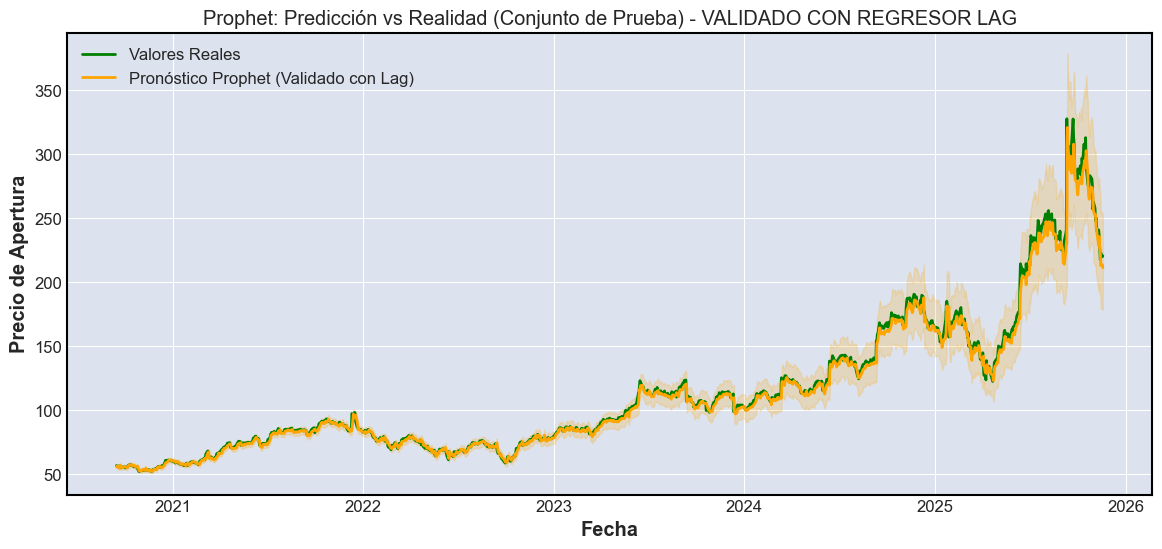

C:\Users\ivanm\AppData\Local\Temp\ipykernel_20228\3113892260.py:107: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future_dates_prophet[col].fillna(historical_data[col], inplace=True)


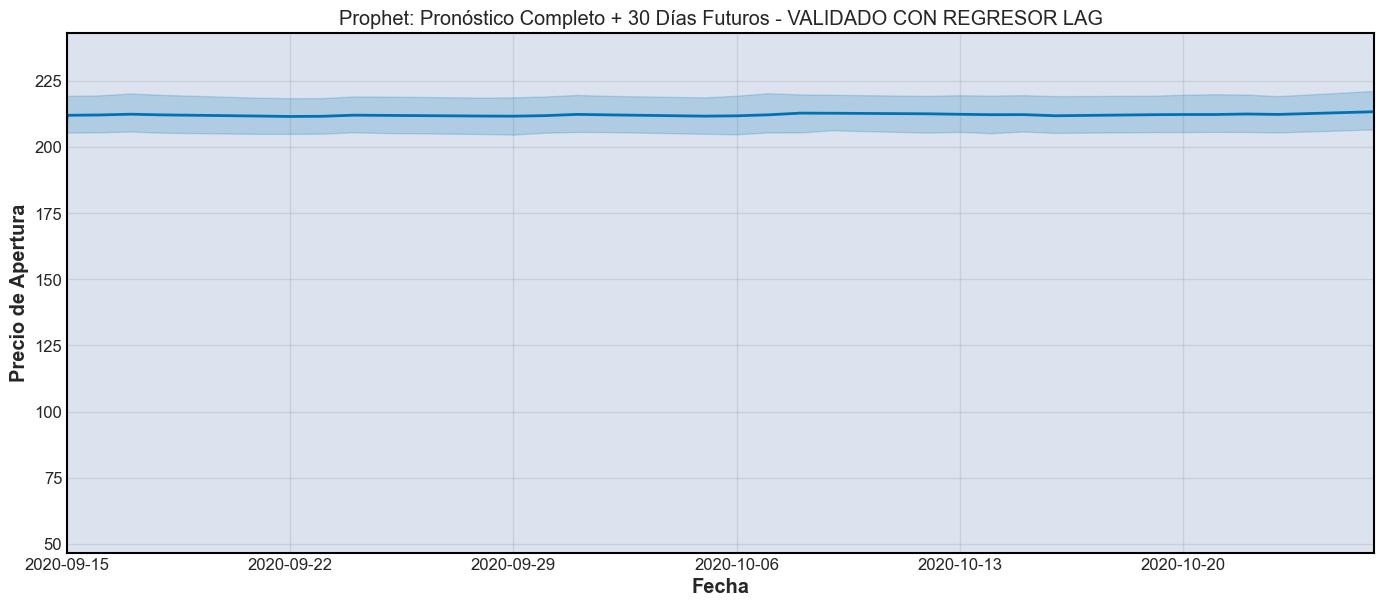

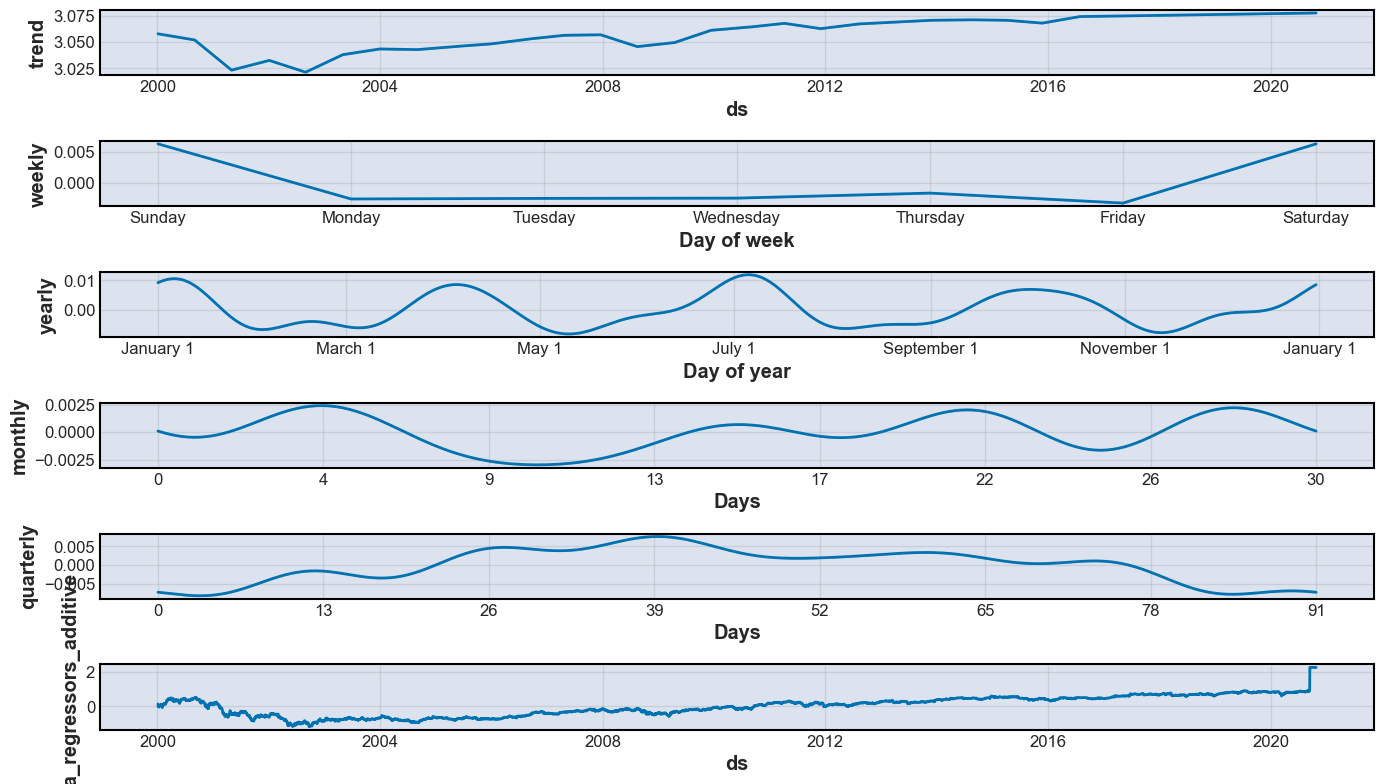

In [44]:
df_prophet = df[['Open', 'High', 'Volume']].reset_index().copy()
df_prophet.columns = ['ds', 'y', 'High', 'Volume']
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# 2. APLICACIÓN DE TRANSFORMACIÓN LOGARÍTMICA
df_prophet['y'] = np.log(df_prophet['y'])

# 3. CREACIÓN DE REGRESORES RETRASADOS (LAGGING)
# Usaremos el log(High) y log(Volume) del día ANTERIOR (t-1) para predecir Open del día t.
# .shift(1) mueve los valores hacia abajo, creando el rezago.
df_prophet['log_high_lagged'] = np.log(df_prophet['High']).shift(1)
df_prophet['log_volume_lagged'] = np.log(df_prophet['Volume']).shift(1)

# Eliminar la primera fila que ahora tiene NaN debido al shift(1)
df_prophet.dropna(inplace=True) 

# 4. División Train/Test (actualizada después de eliminar la primera fila)
train_len_prophet = int(len(df_prophet) * 0.8)
train_prophet = df_prophet.iloc[:train_len_prophet]
test_prophet = df_prophet.iloc[train_len_prophet:]

# --- 3.2 Entrenamiento ---
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.95 
)

# Añadir estacionalidad
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='quarterly', period=91.25, fourier_order=7)

# Añadir regresores externos RETRASADOS
m.add_regressor('log_high_lagged')
m.add_regressor('log_volume_lagged')

m.fit(train_prophet)

# --- 3.3 Predicción (Test Set) ---
# Ahora usamos los valores del día anterior (t-1) del test set para predecir el día actual (t).
# Los regresores en future_test ya son los valores lagged, por lo que son conocidos al momento 't'.
future_test = test_prophet[['ds', 'log_high_lagged', 'log_volume_lagged']].copy()
forecast_test = m.predict(future_test)

# Obtener los valores predichos y reales del conjunto de prueba (EN ESCALA ORIGINAL)
y_true_prophet_log = test_prophet['y'].values
y_pred_prophet_log = forecast_test['yhat'].values

# *** REVERSIÓN DE LA TRANSFORMACIÓN LOGARÍTMICA ***
y_true_prophet = np.exp(y_true_prophet_log)
y_pred_prophet = np.exp(y_pred_prophet_log)
forecast_test['yhat'] = y_pred_prophet
forecast_test['yhat_lower'] = np.exp(forecast_test['yhat_lower'])
forecast_test['yhat_upper'] = np.exp(forecast_test['yhat_upper'])

# --- 3.4 Evaluación Prophet ---
rmse_prophet = np.sqrt(mean_squared_error(y_true_prophet, y_pred_prophet))
r2_prophet = r2_score(y_true_prophet, y_pred_prophet)

print(f'\nProphet RMSE (VALIDADO CON LAG): {rmse_prophet:.4f}')
print(f'Prophet R^2 Score (VALIDADO CON LAG): {r2_prophet:.4f}')

# --- 3.5 Visualización Prophet (Test Set) ---
plt.figure(figsize=(14, 6))
plt.plot(test_prophet['ds'], y_true_prophet, label='Valores Reales', color='green')
plt.plot(test_prophet['ds'], y_pred_prophet, label='Pronóstico Prophet (Validado con Lag)', color='orange')
plt.fill_between(test_prophet['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='orange', alpha=0.2)
plt.title('Prophet: Predicción vs Realidad (Conjunto de Prueba) - VALIDADO CON REGRESOR LAG')
plt.xlabel('Fecha')
plt.ylabel('Precio de Apertura')
plt.legend()
plt.grid(True)
plt.show()

# --- 3.6 Pronóstico a Futuro (30 Días) ---
# Prophet genera las fechas futuras automáticamente
future_dates_prophet = m.make_future_dataframe(periods=30, freq='B')

# --- Preparar Regresores para el Pronóstico Futuro ---
# Para los 30 días futuros, debemos proporcionar valores para los regresores.
# Usaremos el último valor conocido del regresor como un estimador constante para todo el futuro.
last_log_high_lagged = df_prophet['log_high_lagged'].iloc[-1]
last_log_volume_lagged = df_prophet['log_volume_lagged'].iloc[-1]

# Llenar las columnas de regresores para el futuro (solo para las nuevas filas)
future_dates_prophet['log_high_lagged'] = np.nan
future_dates_prophet['log_volume_lagged'] = np.nan

# Identificar las filas de pronóstico (donde 'ds' es mayor que el último ds de entrenamiento)
last_train_ds = train_prophet['ds'].max()
future_indices = future_dates_prophet[future_dates_prophet['ds'] > last_train_ds].index

# Rellenar solo las filas futuras con el último valor conocido.
future_dates_prophet.loc[future_indices, 'log_high_lagged'] = last_log_high_lagged
future_dates_prophet.loc[future_indices, 'log_volume_lagged'] = last_log_volume_lagged

# Para que Prophet pueda predecir, las filas históricas (donde ds <= last_train_ds)
# también deben tener los regresores. Usamos los valores reales de df_prophet para rellenar
# las filas históricas en future_dates_prophet
historical_data = df_prophet[['ds', 'log_high_lagged', 'log_volume_lagged']]
future_dates_prophet.set_index('ds', inplace=True)
historical_data.set_index('ds', inplace=True)

# Actualizar las columnas históricas
for col in ['log_high_lagged', 'log_volume_lagged']:
    future_dates_prophet[col].fillna(historical_data[col], inplace=True)

future_dates_prophet.reset_index(inplace=True)

forecast_future_prophet = m.predict(future_dates_prophet)

# *** REVERSIÓN DE LA TRANSFORMACIÓN LOGARÍTMICA ***
forecast_future_prophet['yhat'] = np.exp(forecast_future_prophet['yhat'])
forecast_future_prophet['yhat_lower'] = np.exp(forecast_future_prophet['yhat_lower'])
forecast_future_prophet['yhat_upper'] = np.exp(forecast_future_prophet['yhat_upper'])


# Gráfico final de Prophet
fig1 = m.plot(forecast_future_prophet, figsize=(14, 6))
plt.title('Prophet: Pronóstico Completo + 30 Días Futuros - VALIDADO CON REGRESOR LAG')
plt.xlabel('Fecha')
plt.ylabel('Precio de Apertura')
# Zoom en la parte final
plt.xlim(test_prophet['ds'].min(), forecast_future_prophet['ds'].max())
plt.ylim(y_true_prophet.min() * 0.9, forecast_future_prophet['yhat_upper'].max() * 1.1)
plt.show()

# Opcional: Ver componentes (después de la transformación inversa)
fig2 = m.plot_components(forecast_future_prophet, figsize=(14, 8))
plt.show()

# RNN

We will conduct the modeling of a Vanilla RNN very similar to what we did with the LSTM model

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(RNNModel, self).__init__()
        # We simply swap nn.LSTM for nn.RNN here
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The forward pass is identical for this structure
        # out shape: (batch_size, seq_len, hidden_size)
        out, _ = self.rnn(x)
        
        # We take the output from the last time step to feed into the linear layer
        out = self.linear(out[:, -1, :])
        return out

print("Initializing RNN Model...")
print(f"Training on device: {device}")

input_size = 1
num_layers = 3  # Increased number of layers
hidden_size = 128  # Increased number of hidden units
output_size = 1
dropout = 0.2  # Added dropout for regularization

# Initialize the RNN model
rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)

# Loss and Optimizer
loss_fn = nn.MSELoss(reduction='mean')
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=1e-3)

# Lists to store losses for plotting
rnn_train_hist = []
rnn_test_hist = []

# Training Loop
for epoch in range(num_epochs): # Uses the same num_epochs as LSTM
    total_loss = 0.0
    rnn_model.train()
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        predictions = rnn_model(batch_X)
        loss = loss_fn(predictions, batch_y)
        
        # Backward pass and optimize
        optimizer_rnn.zero_grad()
        loss.backward()
        optimizer_rnn.step()
        
        total_loss += loss.item()
    
    # Calculate average training loss
    average_loss = total_loss / len(train_loader)
    rnn_train_hist.append(average_loss)
    
    # Validation Loop
    rnn_model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = rnn_model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)
            total_test_loss += test_loss.item()
            
        average_test_loss = total_test_loss / len(test_loader)
        rnn_test_hist.append(average_test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - RNN Train Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Starting RNN Training...
Epoch [10/100] - RNN Train Loss: 0.0005, Test Loss: 0.0003
Epoch [20/100] - RNN Train Loss: 0.0004, Test Loss: 0.0004
Epoch [30/100] - RNN Train Loss: 0.0004, Test Loss: 0.0004
Epoch [40/100] - RNN Train Loss: 0.0003, Test Loss: 0.0003
Epoch [50/100] - RNN Train Loss: 0.0004, Test Loss: 0.0003
Epoch [60/100] - RNN Train Loss: 0.0003, Test Loss: 0.0004
Epoch [70/100] - RNN Train Loss: 0.0003, Test Loss: 0.0004
Epoch [80/100] - RNN Train Loss: 0.0033, Test Loss: 0.0029
Epoch [90/100] - RNN Train Loss: 0.0012, Test Loss: 0.0013
Epoch [100/100] - RNN Train Loss: 0.0010, Test Loss: 0.0011


## Loss function for RNN

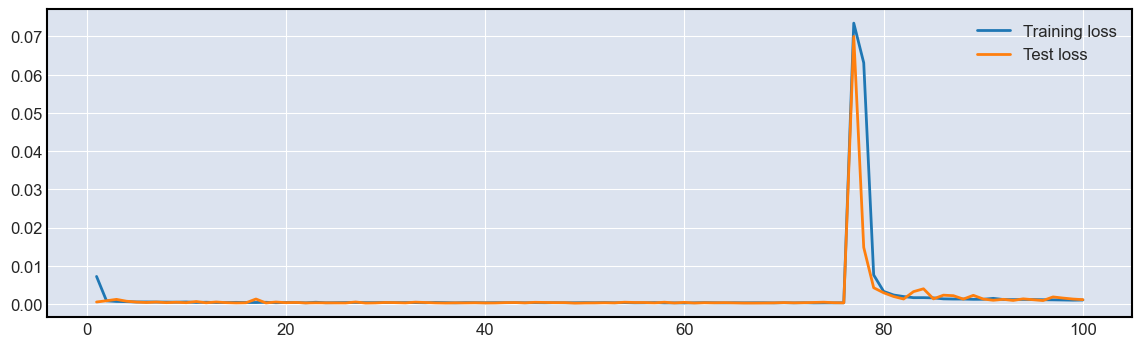

In [37]:
x = np.linspace(1, num_epochs, num_epochs)
plt.plot(x, rnn_train_hist, scalex=True, label="Training loss")
plt.plot(x, rnn_test_hist, label="Test loss")
plt.legend()
plt.show()

## Forecasting with RNN

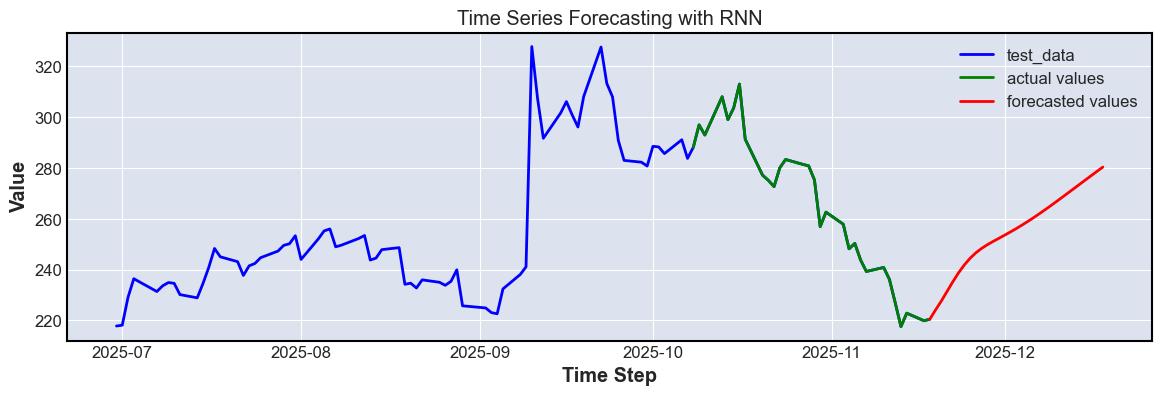

RMSE: 0.0331
R² Score: 0.9726


In [41]:
num_forecast_steps = 30
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(test_data.index[-100:], test_data.Open[-100:], label="test_data", color="b")
plt.plot(test_data.index[-30:], test_data.Open[-30:], label='actual values', color='green')
plt.plot(test_data.index[-1:].append(future_dates), np.concatenate([test_data.Open[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()]), label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting with RNN')
plt.grid(True)
plt.show()

# --- Evaluation Metrics ---
rnn_model.eval()
with torch.no_grad():
    rnn_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)
        rnn_predictions.append(rnn_model(batch_X_test).cpu().numpy().flatten()[0])

rnn_predictions = np.array(rnn_predictions)

# Calculate RMSE and R² score
rnn_rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), rnn_predictions))
rnn_r2 = r2_score(y_test.cpu().numpy(), rnn_predictions)
print(f'RMSE: {rnn_rmse:.4f}')
print(f'R² Score: {rnn_r2:.4f}')

RNN Model Performance:
RMSE: 0.0331
R2 Score: 0.9726


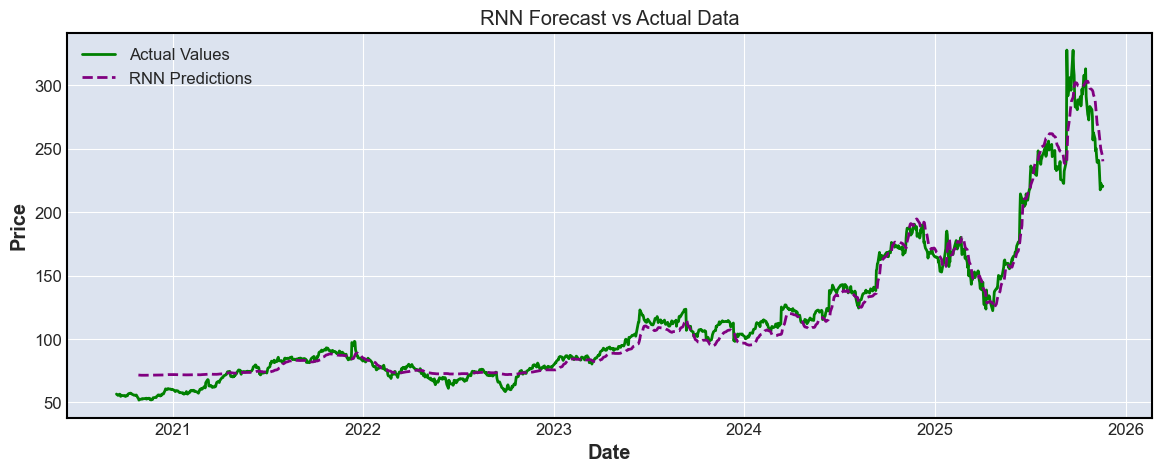

In [43]:
# --- Evaluation Metrics ---
rnn_model.eval()
with torch.no_grad():
    rnn_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)
        rnn_predictions.append(rnn_model(batch_X_test).cpu().numpy().flatten()[0])

rnn_predictions = np.array(rnn_predictions)

# Calculate Metrics
rnn_rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), rnn_predictions))
rnn_r2 = r2_score(y_test.cpu().numpy(), rnn_predictions)

print(f"RNN Model Performance:")
print(f"RMSE: {rnn_rmse:.4f}")
print(f"R2 Score: {rnn_r2:.4f}")

# --- Plotting Predictions vs Actual ---
plt.figure(figsize=(14, 5))
plt.plot(test_data.index, test_data.Open, label='Actual Values', color='green')
# We need to align predictions with dates (remember we lose `sequence_length` points at the start)
# The predictions start from index `sequence_length` of the test data
plt.plot(test_data.index[sequence_length:], scaler.inverse_transform(rnn_predictions.reshape(-1, 1)), label='RNN Predictions', color='purple', linestyle='--')
plt.title('RNN Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()